=== ELBOW METHOD ===


  File "c:\Users\abdul\anaconda3\envs\dataS\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\abdul\anaconda3\envs\dataS\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\abdul\anaconda3\envs\dataS\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\User

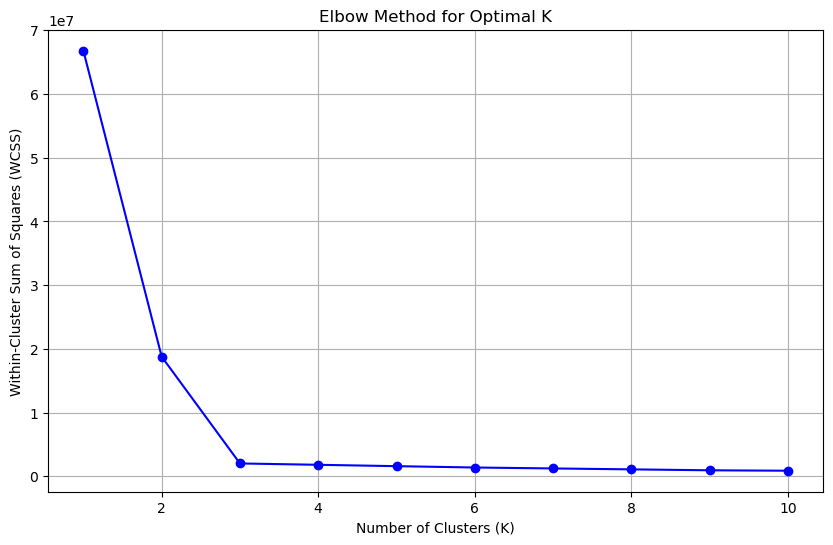

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
import warnings

warnings.filterwarnings("ignore")

# Generate sample large dataset (replace with your actual data)
X, _ = make_blobs(n_samples=1000000, centers=3, n_features=2, random_state=42)


def elbow_method(X, max_k=10):
    wcss = []  # Within-Cluster Sum of Squares

    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    # Plot elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_k + 1), wcss, "bo-")
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
    plt.title("Elbow Method for Optimal K")
    plt.grid(True)
    plt.show()

    return wcss


# Find optimal K using elbow method
print("=== ELBOW METHOD ===")
wcss = elbow_method(X)

In [ ]:
def silhouette_analysis(X, max_k=10):
    silhouette_scores = []

    for k in range(2, max_k + 1):  # silhouette requires k >= 2
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        silhouette_avg = silhouette_score(X, labels)
        silhouette_scores.append(silhouette_avg)
        print(f"K={k}, Silhouette Score: {silhouette_avg:.4f}")

    # Plot silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_k + 1), silhouette_scores, "ro-")
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Analysis for Optimal K")
    plt.grid(True)
    plt.show()

    optimal_k = np.argmax(silhouette_scores) + 2
    print(f"Optimal K based on silhouette: {optimal_k}")
    return optimal_k


print("\n=== SILHOUETTE ANALYSIS ===")
optimal_k = silhouette_analysis(X)


=== SILHOUETTE ANALYSIS ===


In [ ]:
from sklearn.utils import shuffle
import scipy


def gap_statistic(X, max_k=10, n_refs=3):
    """Calculate Gap statistic for optimal K"""
    gaps = []

    for k in range(1, max_k + 1):
        # Fit K-Means to actual data
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        wcss = kmeans.inertia_

        # Generate reference datasets
        reference_wcss = []
        for _ in range(n_refs):
            # Create reference dataset by shuffling each feature
            reference = np.array([shuffle(X[:, i]) for i in range(X.shape[1])]).T
            kmeans_ref = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans_ref.fit(reference)
            reference_wcss.append(kmeans_ref.inertia_)

        # Calculate gap
        gap = np.log(np.mean(reference_wcss)) - np.log(wcss)
        gaps.append(gap)
        print(f"K={k}, Gap: {gap:.4f}")

    # Find optimal K (first k where gap(k) >= gap(k+1) - std(k+1))
    optimal_k = 1
    for k in range(len(gaps) - 1):
        if gaps[k] >= gaps[k + 1]:  # - np.std(gaps) can be added for more robustness
            optimal_k = k + 1
            break

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_k + 1), gaps, "go-")
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Gap Value")
    plt.title("Gap Statistic for Optimal K")
    plt.grid(True)
    plt.show()

    print(f"Optimal K based on gap statistic: {optimal_k}")
    return optimal_k


print("\n=== GAP STATISTIC ===")
gap_optimal_k = gap_statistic(X[:10000])  # Use subset for faster computation

In [ ]:
from sklearn.cluster import MiniBatchKMeans
import time


def scalable_kmeans(X, k=3, sample_size=100000):
    """Use MiniBatch K-Means for large datasets"""

    print(f"Dataset shape: {X.shape}")
    print(f"Using MiniBatch K-Means with k={k}")

    # Method 1: Use MiniBatch K-Means on full data
    start_time = time.time()
    mbk = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000)
    mbk_labels = mbk.fit_predict(X)
    mbk_time = time.time() - start_time

    print(f"MiniBatch K-Means completed in {mbk_time:.2f} seconds")
    print(f"Final centroids:\n{mbk.cluster_centers_}")

    return mbk, mbk_labels


# Apply scalable K-Means
print("=== SCALABLE K-MEANS FOR LARGE DATASETS ===")
kmeans_model, labels = scalable_kmeans(X, k=optimal_k)

In [ ]:
def sampling_kmeans(X, k=3, sample_size=100000, random_state=42):
    """Use sampling for very large datasets"""

    print(f"Original dataset size: {X.shape}")

    # Take a random sample
    np.random.seed(random_state)
    sample_indices = np.random.choice(X.shape[0], sample_size, replace=False)
    X_sample = X[sample_indices]

    print(f"Sample dataset size: {X_sample.shape}")

    # Find optimal K on sample
    print("Finding optimal K on sample...")
    sample_optimal_k = silhouette_analysis(X_sample, max_k=8)

    # Train on sample
    start_time = time.time()
    kmeans_sample = KMeans(n_clusters=sample_optimal_k, random_state=42, n_init=10)
    kmeans_sample.fit(X_sample)

    # Assign all points to clusters using sampled centroids
    all_labels = kmeans_sample.predict(X)
    total_time = time.time() - start_time

    print(f"Sampling K-Means completed in {total_time:.2f} seconds")
    print(f"Optimal K from sample: {sample_optimal_k}")

    return kmeans_sample, all_labels


print("\n=== SAMPLING APPROACH ===")
sample_model, sample_labels = sampling_kmeans(X, sample_size=50000)